In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.colors import LogNorm,Normalize
import scipy as sp
from scipy.linalg import *
from matplotlib.pyplot import gca
import pandas as pd

In [2]:
tr_file  = "ap17_xpcont_train.pickle"
val_file = "ap17_xpcont_validation.pickle"

with open(tr_file, 'rb') as f1:
    data_tr = pickle.load(f1)

with open(val_file, 'rb') as f2:
    data_val = pickle.load(f2)
    
print("Keys of training set and validation set are:")
print(data_tr.keys(), "\n", data_val.keys(), '\n')

print("Array shape of training set and validation set are:")
print([data_tr[_].shape for _ in data_tr.keys()], "\n", [data_val[_].shape for _ in data_val.keys()])

Keys of training set and validation set are:
dict_keys(['bp_coef', 'rp_coef', 'labels']) 
 dict_keys(['bp_coef', 'rp_coef', 'labels']) 

Array shape of training set and validation set are:
[(4000, 55), (4000, 55), (4000, 2)] 
 [(1000, 55), (1000, 55), (1000, 2)]


#### 4000 data points for training, 1000 for validation. 55 RP coeff, 55 BP coeff. As for labels, there are 2 columns; 1st col is T_eff, 2nd is log|g|

### $T_{eff}$ v. $log|g|$ plot

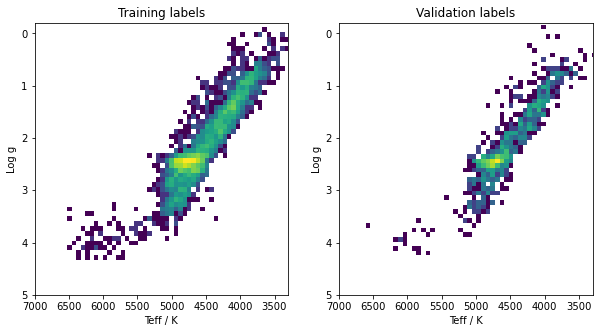

In [3]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

for i, ax in enumerate(axs.ravel()): 
    
    if i==0:
        ax.hist2d(
        data_tr['labels'][:,0], data_tr['labels'][:,1],
        bins=50, norm=LogNorm());
        ax.set_title("Training labels");
    else:
        ax.hist2d(
        data_val['labels'][:,0], data_val['labels'][:,1],
        bins=50, norm=LogNorm());
        ax.set_title("Validation labels");
        
    ax.set_xlim([7000, 3300]);
    ax.set_ylim([5, -0.2]);
    ax.set_xlabel("Teff / K");
    ax.set_ylabel("Log g");

## Q1. BP and RP coefficients are the inputs. The labels are $T_{eff}$. Use Linear Regression to learn a function that takes in these inputs and gives out labels as outputs. Train on training set, and use validation set to...validate. Assess performance using RMS or median absolute deviation.

### Let's start by predicting $T_{eff}$

In [14]:
#TRAINING DATA:
Y_data_train = data_tr['labels'][:,0] #T_eff. Col vector of n = 4000
max_rp = np.max(data_tr['rp_coef'])
X_bp = data_tr['bp_coef']/max_rp
X_rp = data_tr['rp_coef']/max_rp
X_data_train = np.dstack((X_bp, X_rp)) #X_data has shape (4000, 55, 2)

#VALIDATION DATA:
Y_data_val = data_val['labels'][:,0] #T_eff. Col vector of n = 1000
max_rp = np.max(data_val['rp_coef'])
X_bp = data_val['bp_coef']/max_rp
X_rp = data_val['rp_coef']/max_rp
X_data_val = np.dstack((X_bp, X_rp)) #X_data has shape (1000, 55, 2)

### Remember that linear regression is performed by minimizing some loss function. The loss function $||Y-X^{T}\Theta||^{2}_{2} + \alpha||\Theta||^{2}_{2}$, with the second term offerring stability during minimization. 
### The solution is $\hat{\Theta} = (X^T X + \alpha\,\mathbb{I}_{p})^{-1} X^T Y$

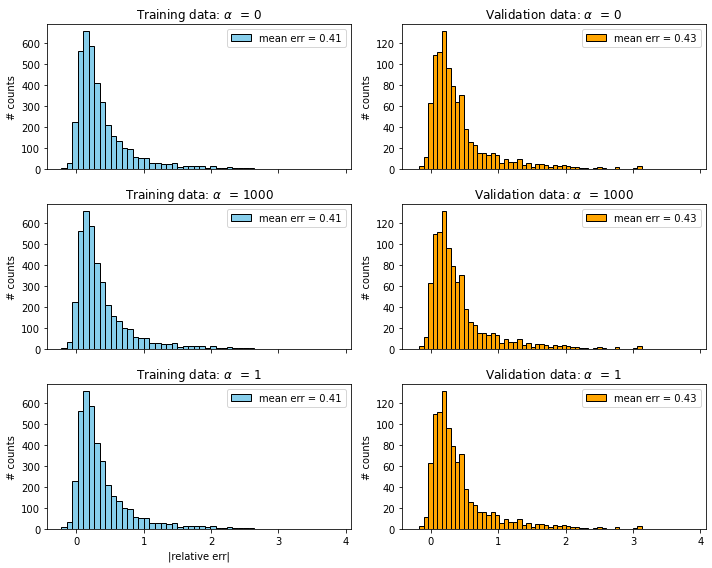

In [15]:
def get_theta(X_data, Y_data, alpha): #set alpha to 0 for no RIDGE
    #add a bunch of ones to X_data
    X_data = np.stack((X_data, np.ones(X_data.shape)), axis = 3) #new shape is (4000, 55, 2, 2)
    Xt_data = np.transpose(X_data) #transpose with shape (2, 2, 55, 4000)
    Y_data = np.expand_dims(Y_data, 1)
    #cast equation as type (A+R)^-1*C, with (A+R)^-1 = B. 
    A = np.tensordot(Xt_data, X_data, ((3,2,1), (0,1,2)))
    R = alpha * np.identity(A.shape[0])
    B = np.linalg.solve(A+R, np.identity(A.shape[0]))
    C = Xt_data.dot(Y_data)
    theta = solve(A, C)
    return theta

fig, ax = plt.subplots(3,2, figsize = (10,8), sharex=True) #1st col is training, 2nd col is validation. Three rows for different alpha
ax[2,0].set_xlabel('|relative err|')

def get_Y_err(X_data, Y_data, alpha): #X_data, Y_data can be from training or from validation
    theta = get_theta(X_data, Y_data, alpha)
    X_data = np.stack((X_data, np.ones(X_data.shape)), axis = 3) #new shape is (4000, 55, 2, 2)
    Y_data = Y_data[:, np.newaxis]
    Y_hat = np.tensordot(X_data, theta, axes=((3,2,1), (0,1,2)))
    Y_err = ((Y_hat-Y_data)/Y_data).flatten() #should be a 4000 col vector
    return Y_err

#first row, first col: training data, alpha = 0
Y_err = get_Y_err(X_data_train, Y_data_train, 0.)
ax[0,0].hist(Y_err, bins = 50, color = "skyblue", ec="black", \
             label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[0,0].legend()
ax[0,0].set_title(r'Training data: $\alpha$  = 0')
ax[0,0].set_ylabel('# counts')

#second row, first col: training data, alpha = 1000
Y_err = get_Y_err(X_data_train, Y_data_train, 1000.)
ax[1,0].hist(Y_err, bins = 50, color = "skyblue", ec="black", \
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[1,0].legend()
ax[1,0].set_title(r'Training data: $\alpha$  = 1000')
ax[1,0].set_ylabel('# counts')

#third row, first col: training data, alpha = 1
Y_err = get_Y_err(X_data_train, Y_data_train, 1)
ax[2,0].hist(Y_err, bins = 50, color = "skyblue", ec="black", \
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[2,0].legend()
ax[2,0].set_title(r'Training data: $\alpha$  = 1')
ax[2,0].set_ylabel('# counts')

print("\n")

#first row, second col: validation data, alpha = 0
Y_err = get_Y_err(X_data_val, Y_data_val, 0.)
ax[0,1].hist(Y_err, bins = 50, color = "orange", ec="black",\
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[0,1].legend()
ax[0,1].set_title(r'Validation data: $\alpha$  = 0')
ax[0,1].set_ylabel('# counts')

#second row, second col: validation data, alpha = 1000
Y_err = get_Y_err(X_data_val, Y_data_val, 1000.)
ax[1,1].hist(Y_err, bins = 50, color = "orange", ec="black",\
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[1,1].legend()
ax[1,1].set_title(r'Validation data: $\alpha$  = 1000')
ax[1,1].set_ylabel('# counts')

#third row, second col: validation data, alpha = 1
Y_err = get_Y_err(X_data_val, Y_data_val, 1.)
ax[2,1].hist(Y_err, bins = 50, color = "orange", ec="black",\
             label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[2,1].legend()
ax[2,1].set_title(r'Validation data: $\alpha$  = 1')
ax[2,1].set_ylabel('# counts')

plt.tight_layout()

#### Results make sense. But I'm not sure why changing $\alpha$ makes no difference. Some error in my code that I must catch

### Q2. Now only look at RP coefficients. Make linear model to predict $T_{eff}$

In [29]:
#TRAINING DATA:
Y_data_train = data_tr['labels'][:,0] #T_eff. Col vector of n = 4000
max_rp = np.max(data_tr['rp_coef'])
X_rp = data_tr['rp_coef']/max_rp
X_data_train = X_rp
print(X_rp.shape)

#VALIDATION DATA:
Y_data_val = data_val['labels'][:,0] #T_eff. Col vector of n = 1000
max_rp = np.max(data_val['rp_coef'])
X_rp = data_val['rp_coef']/max_rp
X_data_val = X_rp
print(X_rp.shape)

(4000, 55)
(1000, 55)


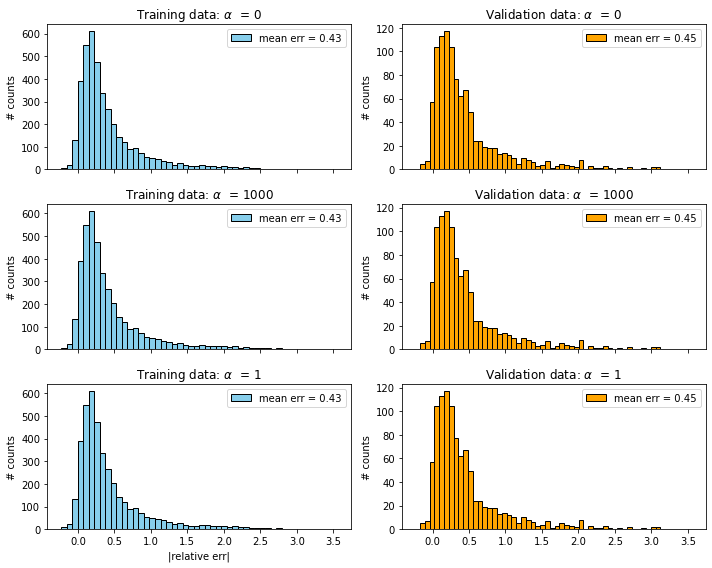

In [17]:
def get_theta(X_data, Y_data, alpha): #set alpha to 0 for no RIDGE
    #add a bunch of ones to X_data
    X_data = np.stack((X_data, np.ones(X_data.shape)), axis = 2)
    Xt_data = np.transpose(X_data)
    Y_data = np.expand_dims(Y_data, 1)
    #cast equation as type (A+R)^-1*C, with (A+R)^-1 = B. 
    A = np.tensordot(Xt_data, X_data, ((2,1), (0,1)))
    R = alpha * np.identity(A.shape[0])
    B = np.linalg.solve(A+R, np.identity(A.shape[0]))
    C = Xt_data.dot(Y_data)
    theta = solve(A, C)
    return theta

fig, ax = plt.subplots(3,2, figsize = (10,8), sharex=True) #1st col is training, 2nd col is validation. Three rows for different alpha
ax[2,0].set_xlabel('|relative err|')

def get_Y_err(X_data, Y_data, alpha): #X_data, Y_data can be from training or from validation
    theta = get_theta(X_data, Y_data, alpha)
    X_data = np.stack((X_data, np.ones(X_data.shape)), axis = 2) 
    Y_data = Y_data[:, np.newaxis]
    Y_hat = np.tensordot(X_data, theta, axes=((2,1), (0,1)))
    Y_err = ((Y_hat-Y_data)/Y_data).flatten() 
    return Y_err

#first row, first col: training data, alpha = 0
Y_err = get_Y_err(X_data_train, Y_data_train, 0.)
ax[0,0].hist(Y_err, bins = 50, color = "skyblue", ec="black", \
             label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[0,0].legend()
ax[0,0].set_title(r'Training data: $\alpha$  = 0')
ax[0,0].set_ylabel('# counts')

#second row, first col: training data, alpha = 1000
Y_err = get_Y_err(X_data_train, Y_data_train, 1000.)
ax[1,0].hist(Y_err, bins = 50, color = "skyblue", ec="black", \
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[1,0].legend()
ax[1,0].set_title(r'Training data: $\alpha$  = 1000')
ax[1,0].set_ylabel('# counts')

#third row, first col: training data, alpha = 1
Y_err = get_Y_err(X_data_train, Y_data_train, 1)
ax[2,0].hist(Y_err, bins = 50, color = "skyblue", ec="black", \
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[2,0].legend()
ax[2,0].set_title(r'Training data: $\alpha$  = 1')
ax[2,0].set_ylabel('# counts')

print("\n")

#first row, second col: validation data, alpha = 0
Y_err = get_Y_err(X_data_val, Y_data_val, 0.)
ax[0,1].hist(Y_err, bins = 50, color = "orange", ec="black",\
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[0,1].legend()
ax[0,1].set_title(r'Validation data: $\alpha$  = 0')
ax[0,1].set_ylabel('# counts')

#second row, second col: validation data, alpha = 1000
Y_err = get_Y_err(X_data_val, Y_data_val, 1000.)
ax[1,1].hist(Y_err, bins = 50, color = "orange", ec="black",\
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[1,1].legend()
ax[1,1].set_title(r'Validation data: $\alpha$  = 1000')
ax[1,1].set_ylabel('# counts')

#third row, second col: validation data, alpha = 1
Y_err = get_Y_err(X_data_val, Y_data_val, 1.)
ax[2,1].hist(Y_err, bins = 50, color = "orange", ec="black",\
             label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[2,1].legend()
ax[2,1].set_title(r'Validation data: $\alpha$  = 1')
ax[2,1].set_ylabel('# counts')

plt.tight_layout()

#### Now add quadratic combinations of the RP coefficients to predict $T_{eff}$. Train and assess accuracy.

C:\Users\ajati\AppData\Local\Temp\ipykernel_22700\27586940.py:16: LinAlgWarning: Ill-conditioned matrix (rcond=4.45162e-36): result may not be accurate.
  theta = solve(A, C)


C:\Users\ajati\AppData\Local\Temp\ipykernel_22700\27586940.py:16: LinAlgWarning: Ill-conditioned matrix (rcond=1.80836e-35): result may not be accurate.
  theta = solve(A, C)


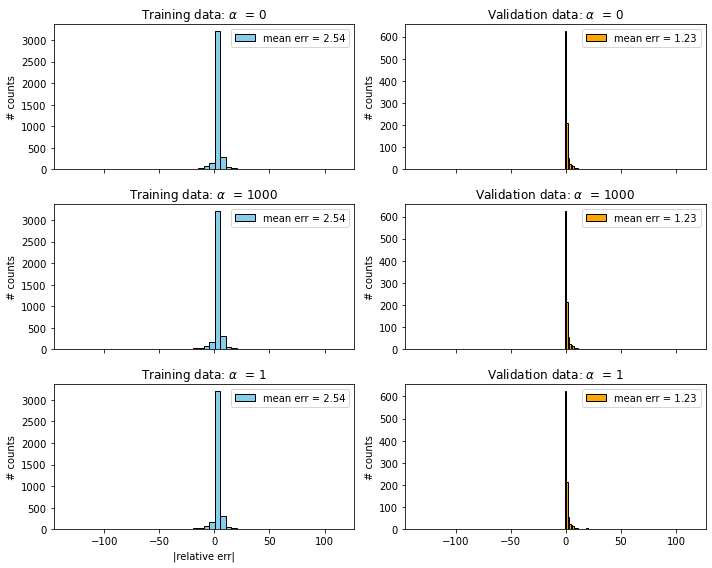

In [42]:
def get_theta(X_data, Y_data, alpha): 
    #This time, we also want quadratic combination
    X_sq_data = np.square(X_data)
    #also get the cross terms
    X_cross = []
    for i in range(X_data.shape[1]):
        X_cross.append(X_data*np.roll(np.copy(X_data), i, axis=1))
    X_data = np.stack((X_sq_data, *X_cross, X_data, np.ones(X_data.shape)), axis = 2)
    Xt_data = np.transpose(X_data)
    Y_data = Y_data[:, np.newaxis]
    #cast equation as type (A+R)^-1*C, with (A+R)^-1 = B. 
    A = np.tensordot(Xt_data, X_data, axes=((2,1), (0,1)))
    R = alpha * np.identity(A.shape[0])
    B = np.linalg.solve(A+R, np.identity(A.shape[0]))
    C = Xt_data.dot(Y_data)
    theta = solve(A, C)
    return theta

fig, ax = plt.subplots(3,2, figsize = (10,8), sharex=True) #1st col is training, 2nd col is validation. Three rows for different alpha
ax[2,0].set_xlabel('|relative err|')

def get_Y_err(X_data, Y_data, alpha): #X_data, Y_data can be from training or from validation
    theta = get_theta(X_data, Y_data, alpha)
    X_sq_data = np.square(X_data)
    #also get the cross terms
    X_cross = []
    for i in range(0, X_data.shape[1]):
        X_cross.append(X_data*np.roll(np.copy(X_data), i, axis=1))
    X_data = np.stack((X_sq_data, *X_cross, X_data, np.ones(X_data.shape)), axis = 2)
    Y_data = np.expand_dims(Y_data, 1)
    Y_hat = np.tensordot(X_data, theta, axes=((2,1), (0,1)))
    Y_err = ((Y_hat-Y_data)/Y_data).flatten() 
    return Y_err

#first row, first col: training data, alpha = 0
Y_err = get_Y_err(X_data_train, Y_data_train, 0.)
ax[0,0].hist(Y_err, bins = 50, color = "skyblue", ec="black", \
             label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[0,0].legend()
ax[0,0].set_title(r'Training data: $\alpha$  = 0')
ax[0,0].set_ylabel('# counts')

#second row, first col: training data, alpha = 1000
Y_err = get_Y_err(X_data_train, Y_data_train, 1000.)
ax[1,0].hist(Y_err, bins = 50, color = "skyblue", ec="black", \
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[1,0].legend()
ax[1,0].set_title(r'Training data: $\alpha$  = 1000')
ax[1,0].set_ylabel('# counts')

#third row, first col: training data, alpha = 1
Y_err = get_Y_err(X_data_train, Y_data_train, 1)
ax[2,0].hist(Y_err, bins = 50, color = "skyblue", ec="black", \
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[2,0].legend()
ax[2,0].set_title(r'Training data: $\alpha$  = 1')
ax[2,0].set_ylabel('# counts')

print("\n")

#first row, second col: validation data, alpha = 0
Y_err = get_Y_err(X_data_val, Y_data_val, 0.)
ax[0,1].hist(Y_err, bins = 50, color = "orange", ec="black",\
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[0,1].legend()
ax[0,1].set_title(r'Validation data: $\alpha$  = 0')
ax[0,1].set_ylabel('# counts')

#second row, second col: validation data, alpha = 1000
Y_err = get_Y_err(X_data_val, Y_data_val, 1000.)
ax[1,1].hist(Y_err, bins = 50, color = "orange", ec="black",\
              label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[1,1].legend()
ax[1,1].set_title(r'Validation data: $\alpha$  = 1000')
ax[1,1].set_ylabel('# counts')

#third row, second col: validation data, alpha = 1
Y_err = get_Y_err(X_data_val, Y_data_val, 1.)
ax[2,1].hist(Y_err, bins = 50, color = "orange", ec="black",\
             label='mean err = {}'.format(np.round(np.mean(Y_err),2)))
ax[2,1].legend()
ax[2,1].set_title(r'Validation data: $\alpha$  = 1')
ax[2,1].set_ylabel('# counts')

plt.tight_layout()

#### Did that just make it all worse? @Hogg, I don't know what's happening. Also, weird how the relative error average is smaller for validation data -- it's one of those instances where "more data" increases the error

### Q3. Go back to pset02 (surprise surprise!). Fit with a single Gaussian Process. Use the Matern 3/2 Kernel

### Matern 3/2 Kernel ($\nu = 3/2$): $C_{3/2}(d) = \sigma^2\bigg(1+\frac{\sqrt{3}d}{\xi}\bigg)\exp\{-\frac{\sqrt{3}d}{\xi}\}$ (two points separated at $d$, $\xi$ is like a correlation distance -- can also formulate all this in temporal space instead of distances)
### The fitting is done as: $\hat{Y_{*}} = K_{*}(K+C)^{-1}Y$, where $\hat{Y_{*}}$ is predictions for the test data, $C$ is variance matrix, $K$ is the kernel, $Y$ is data. Evidently, $K$ and $C$ have the same dimensions, say $n\times n$, but $K_{*}$ must have units of $n_{*}\times n$.

In [48]:
df = pd.read_pickle("./data.pkl") 

params_dict = {} #save fit parameters here
err_dict = {}

#plot dataset
X_data = df[:,0]
Y_data_err = df[:,1]
Y_data = df[:,-1]
#all 1024 vectors. Phew! Tired of tensors

(1024,) (1024,) (1024,)


### Plot the GP result by evaluating the GP on a set of test locations which is a fine grid of spacing (say) 0.1 days over a footprint that goes from -50 days to 1075 days
### Vary the hyperparameter $\xi$

In [123]:
def mk(d, xi): #matern 3/2 kernel
    return (1+(np.sqrt(3))*d/xi) * np.exp(-np.sqrt(3*d*d)/xi)

def GP(xi):
    
    #training and testing data
    X_test = np.arange(-50, 1075, 0.1)
    Y_train = Y_data[:, np.newaxis]
    #The goal is to use what we have to make predictions Y_test at the test data points X_test.

    #define C, K, K*
    dim = X_data.shape[0]
    C_train = np.identity(dim)
    var = [s**2 for s in Y_data_err]
    np.fill_diagonal(C_train, var)
    d = np.subtract.outer(X_data, X_data) #distances
    d_star = np.subtract.outer(X_test, X_data)
    K = mk(d, xi=1)
    K_star = mk(d_star, xi)

    A = np.linalg.solve(K+C_train, np.identity(dim))
    Y_test = K_star.dot(A).dot(Y_train)

    fig, ax = plt.subplots()
    ax.errorbar(X_data, Y_data, yerr = Y_data_err, marker = 'o', c = 'steelblue', alpha = 0.2, label = 'data')
    ax.plot(X_test, Y_test, 'k-', label = 'GP')
    ax.set_xlabel(r'$t$ [days]')
    ax.set_ylabel(r'$v$ [m/s]')
    ax.legend()

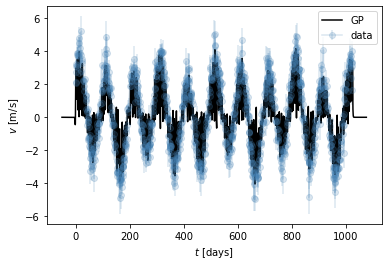

In [124]:
GP(xi = 1)

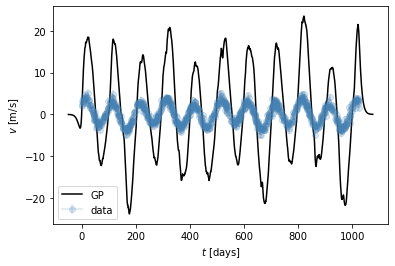

In [125]:
GP(xi = 10)

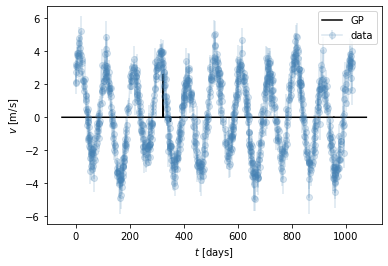

In [126]:
GP(xi = 0.0001)

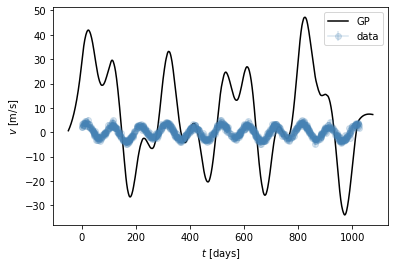

In [127]:
GP(xi = 100)

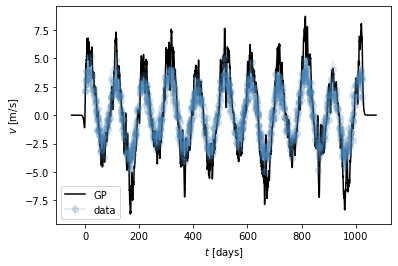

In [131]:
GP(xi = 3)

### As $\xi$ increases, clearly the fits are undertrained. And for very small $\xi$, the fits are overtrained. It looks like a value of about 3 for $\xi$ gives decent results.